In [18]:
import sys, os
import numpy as np
import time, h5py
codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import default_paths, coco_utils, nsd_utils, numpy_utils
from model_fitting import initialize_fitting 
from feature_extraction import texture_statistics_pyramid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import argparse

In [5]:
subject = 1
debug = True


In [19]:
path_to_load = default_paths.sketch_token_feat_path

features_file = os.path.join(path_to_load, 'S%d_features_each_prf.h5py'%(subject))
if not os.path.exists(features_file):
    raise RuntimeError('Looking at %s for precomputed features, not found.'%features_file)   
path_to_save = os.path.join(path_to_load, 'LDA')
if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    
n_prfs = models.shape[0]

print('Loading pre-computed features from %s'%features_file)
t = time.time()
with h5py.File(features_file, 'r') as data_set:
    values = np.copy(data_set['/features'][:,:,0:2])
    data_set.close() 
elapsed = time.time() - t
print('Took %.5f seconds to load file'%elapsed)
features_each_prf = values

zgroup_labels = np.concatenate([np.zeros(shape=(1,150)), np.ones(shape=(1,1))], axis=1)

most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]
Loading pre-computed features from /user_data/mmhender/features/sketch_tokens/S1_features_each_prf.h5py
Took 1.79351 seconds to load file


In [22]:
ims_each_supcat.shape

(12, 10000)

In [20]:
print('Size of features array for this image set is:')
print(features_each_prf.shape)

scores_each_prf = []
wts_each_prf = []
trn_acc_each_prf = []

# Gather semantic labels for the images (COCO super-categories)
coco_trn, coco_val = coco_utils.init_coco()
cat_objects, cat_names, cat_ids, supcat_names, ids_each_supcat = coco_utils.get_coco_cat_info(coco_val)
subject_df = nsd_utils.get_subj_df(subject);
all_coco_ids = np.array(subject_df['cocoId'])
ims_each_supcat = []
for sc, scname in enumerate(supcat_names):
    ims_in_supcat = coco_utils.get_ims_in_supcat(coco_trn, coco_val, scname, all_coco_ids)
    ims_each_supcat.append(ims_in_supcat)
ims_each_supcat = np.array(ims_each_supcat)
supcats_each_image = [np.where(ims_each_supcat[:,ii])[0] for ii in range(ims_each_supcat.shape[1])]

# For now, choosing just the images which have only one super-category present.
ims_to_use = [sc for sc in range(len(supcats_each_image)) if len(supcats_each_image[sc])==1]
supcat_labels = np.array([supcats_each_image[sc] for sc in ims_to_use])
n_each_supcat = [np.sum(supcat_labels==sc) for sc in np.unique(supcat_labels)]
print('\nProportion data labels each super-cat:')
print(supcat_names)
print(n_each_supcat)
print('Total images to use: %d'%np.sum(n_each_supcat))

Size of features array for this image set is:
(10000, 151, 2)
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
loading annotations into memory...
Done (t=14.93s)
creating index...
index created!

Proportion data labels each super-cat:
['furniture', 'sports', 'kitchen', 'electronic', 'accessory', 'appliance', 'food', 'animal', 'vehicle', 'person', 'outdoor', 'indoor']
[179, 31, 16, 61, 37, 87, 258, 1103, 560, 41, 206, 249]
2828


In [154]:
for prf_model_index in range(n_prfs):

    if debug and prf_model_index>1:
        continue

    print('\nProcessing pRF %d of %d'%(prf_model_index, n_prfs))

    features_in_prf = features_each_prf[ims_to_use,:,prf_model_index]
    features_in_prf_z = numpy_utils.zscore_in_groups(features_in_prf, zgroup_labels)

    print('Size of features array for this image set and prf is:')
    print(features_in_prf.shape)

    scores, wts, trn_acc = do_lda(features_in_prf_z, supcat_labels)
    scores_each_prf.append(scores)
    wts_each_prf.append(wts)
    trn_acc_each_prf.append(trn_acc)

fn2save = os.path.join(path_to_save, 'S%d_LDA.npy'%(subject))
print('saving to %s'%fn2save)
np.save(fn2save, {'scores': scores_each_prf,'wts': wts_each_prf, 'trn_acc': trn_acc_each_prf})

    


Processing pRF 0 of 875
Size of features array for this image set and prf is:
(2828, 151)
Running linear discriminant analysis: original size of array is [2828 x 151]
Time elapsed: 0.11629
Training data prediction accuracy = 45.16 pct

Proportion predictions each super-cat:
['furniture', 'sports', 'kitchen', 'electronic', 'accessory', 'appliance', 'food', 'animal', 'vehicle', 'person', 'outdoor', 'indoor']
[76, 21, 22, 41, 35, 52, 138, 2127, 163, 29, 50, 74]

Processing pRF 1 of 875
Size of features array for this image set and prf is:
(2828, 151)
Running linear discriminant analysis: original size of array is [2828 x 151]
Time elapsed: 0.16920
Training data prediction accuracy = 47.81 pct

Proportion predictions each super-cat:
['furniture', 'sports', 'kitchen', 'electronic', 'accessory', 'appliance', 'food', 'animal', 'vehicle', 'person', 'outdoor', 'indoor']
[82, 20, 18, 49, 30, 55, 125, 1873, 390, 28, 57, 101]
saving to /user_data/mmhender/features/sketch_tokens/LDA/S1_LDA.npy


In [64]:
values = features_in_prf_z
categ_labels = supcat_labels

n_features_actual = values.shape[1]
n_trials = values.shape[0]

print('Running linear discriminant analysis: original size of array is [%d x %d]'%(n_trials, n_features_actual))
t = time.time()

X = values; y = np.squeeze(categ_labels)
clf = LinearDiscriminantAnalysis(solver='svd')
clf.fit(X, y)


Running linear discriminant analysis: original size of array is [2828 x 151]


LinearDiscriminantAnalysis()

In [106]:
elapsed = time.time() - t
print('Time elapsed: %.5f'%elapsed)

ypred = clf.predict(X)
trn_acc = np.mean(y==ypred)
print('Training data prediction accuracy = %.2f pct'%(trn_acc*100))

print('\nProportion predictions each super-cat:')
n_each_supcat_pred = [np.sum(ypred==sc) for sc in np.unique(supcat_labels)]
print(supcat_names)
print(n_each_supcat_pred)

scores = clf.transform(X)    
wts = clf.coef_

Time elapsed: 703.66918
Training data prediction accuracy = 47.81 pct

Proportion predictions each super-cat:
['furniture', 'sports', 'kitchen', 'electronic', 'accessory', 'appliance', 'food', 'animal', 'vehicle', 'person', 'outdoor', 'indoor']
[82, 20, 18, 49, 30, 55, 125, 1873, 390, 28, 57, 101]


In [115]:
clf.xbar_.shape

(151,)

In [76]:
wts.shape

(12, 151)

In [71]:
trf.shape

(2828, 12)

In [73]:
scores.shape

(2828, 11)

In [78]:
inter = clf.intercept_
inter.shape

(12,)

In [83]:
classmeans = clf.means_
classmeans.shape

(12, 151)

In [122]:
clf.scalings_.shape

(151, 11)

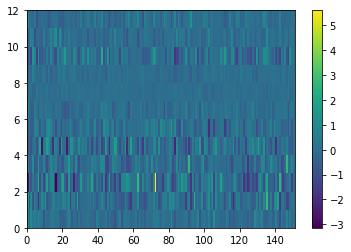

In [129]:
coef = np.dot(clf.means_ - clf.xbar_, clf.scalings_)
coef = np.dot(coef, clf.scalings_.T)
plt.figure();
plt.pcolormesh(coef)
plt.colorbar()

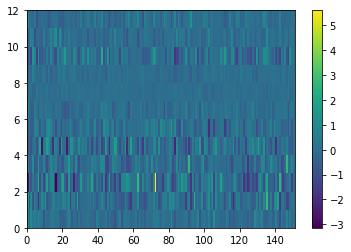

In [128]:
plt.figure();
plt.pcolormesh(clf.coef_)
plt.colorbar()

In [132]:
clf.xbar_[0:10]

array([-0.10462673,  0.11077556, -0.08951485, -0.10101933,  0.06015627,
       -0.0121223 , -0.04385652, -0.00429055, -0.09378146, -0.06026742])

In [133]:
np.mean(X, axis=0)[0:10]

array([-0.10462673,  0.11077556, -0.08951485, -0.10101933,  0.06015627,
       -0.0121223 , -0.04385652, -0.00429055, -0.09378146, -0.06026742])

In [137]:
class_means = np.array([np.mean(X[np.squeeze(supcat_labels)==sc,:], axis=0) for sc in np.unique(supcat_labels)])

In [139]:
class_means[6,0:10]

array([-0.12441868,  0.25477214, -0.06774504, -0.12798977,  0.21362342,
        0.06827359,  0.07436934,  0.20605647,  0.02904029,  0.05795262])

In [141]:
clf.priors_

array([0.06329562, 0.01096181, 0.00565771, 0.02157001, 0.01308345,
       0.03076379, 0.09123055, 0.39002829, 0.1980198 , 0.01449788,
       0.072843  , 0.08804809])

In [143]:
np.array([np.mean(np.squeeze(supcat_labels)==sc) for sc in np.unique(supcat_labels)])

array([0.06329562, 0.01096181, 0.00565771, 0.02157001, 0.01308345,
       0.03076379, 0.09123055, 0.39002829, 0.1980198 , 0.01449788,
       0.072843  , 0.08804809])

In [140]:
clf.means_[6,0:10]

array([-0.12441868,  0.25477214, -0.06774504, -0.12798977,  0.21362342,
        0.06827359,  0.07436934,  0.20605647,  0.02904029,  0.05795262])

In [144]:
# trf = (X - clf.xbar_) @ wts.T

In [150]:
trf = (X - clf.xbar_) @ clf.scalings_

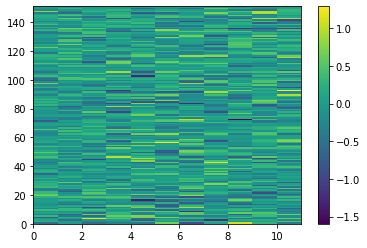

In [148]:
plt.figure();
plt.pcolormesh(clf.scalings_);
plt.colorbar()

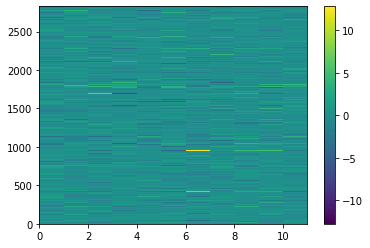

In [151]:
plt.figure();
plt.pcolormesh(trf);
plt.colorbar()

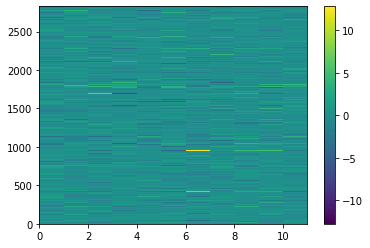

In [152]:
plt.figure();
plt.pcolormesh(scores);
plt.colorbar()

In [89]:
trf[0,:] - inter

array([-1.46070363, -1.18840325,  0.6107007 , -0.04207733,  1.25958401,
       -0.3294126 , -1.22051951,  0.32924049,  0.7898593 , -5.29178573,
       -0.27157399,  0.22282839])

In [80]:
scores[0,:]

array([ 0.73205622,  0.45539083,  0.96200311, -0.75644037,  0.81966442,
       -0.74189072,  0.14092345, -0.75050687,  0.83845971,  2.5669974 ,
       -0.13464792])

In [75]:
trf[0:10,0]

array([-1.46070363, -0.20706511, -1.17573727, -0.0577867 , -0.19579916,
       -1.17538395, -0.19995965, -0.20590757, -1.07319143, -0.05142614])

In [153]:
    
def do_lda(values, categ_labels):
    """
    Apply linear discriminant analysis to the data - find axes that best separate the given category labels.
    """
    n_features_actual = values.shape[1]
    n_trials = values.shape[0]
    
    print('Running linear discriminant analysis: original size of array is [%d x %d]'%(n_trials, n_features_actual))
    t = time.time()
    
    X = values; y = np.squeeze(categ_labels)
    clf = LinearDiscriminantAnalysis(solver='svd')
    clf.fit(X, y)

    elapsed = time.time() - t
    print('Time elapsed: %.5f'%elapsed)
    
    ypred = clf.predict(X)
    trn_acc = np.mean(y==ypred)
    print('Training data prediction accuracy = %.2f pct'%(trn_acc*100))

    print('\nProportion predictions each super-cat:')
    n_each_supcat_pred = [np.sum(ypred==sc) for sc in np.unique(supcat_labels)]
    print(supcat_names)
    print(n_each_supcat_pred)

    # Transform method is doing : scores = (X - clf.xbar_) @ clf.scalings_
    # So the "scalings" define a mapping from mean-centered feature data to the LDA subspace.
    scores = clf.transform(X)    
    scalings = clf.scalings_
   
    return scores, scalings, trn_acc


Loading images for subject 1

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255
['vehicle' 'person' 'outdoor']


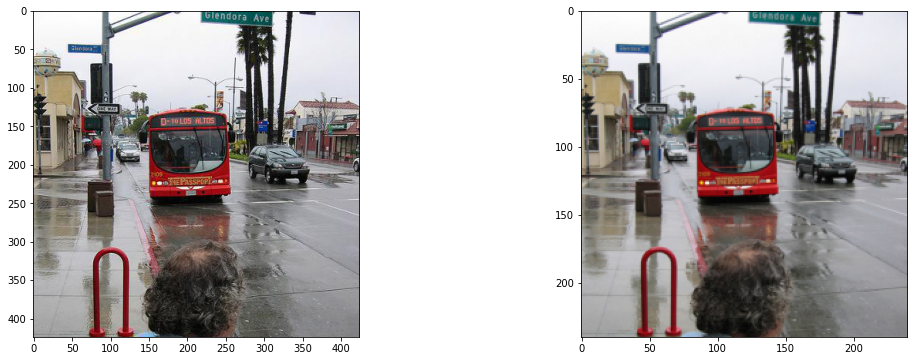

In [51]:
import PIL
import matplotlib.pyplot as plt
# Double check that the coco labels are correct
imageind = 8000
cocoid = np.array(subject_df['cocoId'])[imageind]
cocoim = '/lab_data/tarrlab/common/datasets/NSD_images/images/%d.jpg'%cocoid
im = PIL.Image.open(cocoim)

plt.figure(figsize=(18,6));
plt.subplot(1,2,1)
plt.imshow(im)

ims = nsd_utils.get_image_data(subject)
plt.subplot(1,2,2)
plt.imshow(np.moveaxis(ims[imageind,:,:,:],[0,1,2],[2,0,1]))

print(np.array(supcat_names)[supcats_each_image[imageind]])